In [2]:
import xarray as xr
import sys
sys.path.append("../../")

In [3]:
#Case study needs fixing 
glofas = xr.open_mfdataset('../../data/glofas_sample/Elbe/glofas_masked_elbe_*.nc')


/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [4]:
from functions.floodmodel_utils import get_basin_mask, get_river_mask

In [5]:
eps = xr.open_dataset('/Volumes/portableHardDisk/data/EPS/europeEPS201305/glofas2.1_2018_areagrid_for_StevenGong_in_Europe_2013051700.nc')

In [6]:
era5 = xr.open_mfdataset("/Volumes/portableHardDisk/data/Elbe/reanalysis-era5-single-levels_convective_precipitation,land_sea_mask,large_scale_precipitation,runoff,slope_of_sub_gridscale_orography,soil_type,total_column_water_vapour,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2_*.nc", combine="by_coords")

In [7]:
eps = eps.rename({'lat': 'latitude'})
eps = eps.rename({'lon': 'longitude'})

eps

<xarray.Dataset>
Dimensions:    (ensemble: 11, latitude: 450, longitude: 750, time: 31)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-17 2013-05-18 ... 2013-06-16
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 49.75 49.85 49.95
  * latitude   (latitude) float32 74.95 74.85 74.75 74.65 ... 30.25 30.15 30.05
  * ensemble   (ensemble) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    ups        (latitude, longitude) float32 ...
    ldd        (latitude, longitude) float32 ...
    rl2        (latitude, longitude) float32 ...
    rl5        (latitude, longitude) float32 ...
    rl20       (latitude, longitude) float32 ...
    dis        (time, ensemble, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Fri Feb 14 21:26:30 2020: cdo -f nc4 -z zip copy tmp.nc /vo...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

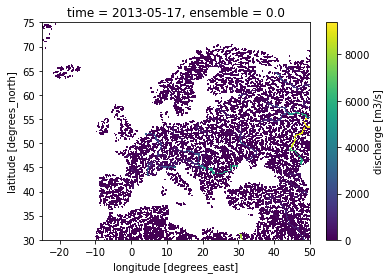

In [8]:
eps.isel(time=0, ensemble=0)['dis'].plot()

In [9]:
elbe_basin_mask = get_basin_mask(eps.isel(time=0, ensemble=0)['dis'], 'Elbe')

In [10]:
elbe_basin_mask2 = get_basin_mask(glofas['dis24'].isel(time=0), 'Elbe')

In [11]:
#First converting LSTM predictions
#Reshape to align in coordinates, glofas is already a masked dataset
era5_masked = era5.interp(latitude=glofas.latitude, longitude=glofas.longitude).where(elbe_basin_mask2, drop=True)
X = era5_masked


#Downsampling our time from hourly to daily
X = X.resample(time='1D').mean()


In [12]:
X

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 71, time: 7638)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-11-29
  * latitude   (latitude) float64 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * longitude  (longitude) float64 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    lsp        (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    slor       (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    slt        (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>

In [13]:
X_point = X.isel(latitude=3, longitude=6)

In [14]:
y_point = glofas['dis24'].isel(latitude=3, longitude=6)

In [15]:
X_point = X_point.drop(['latitude','longitude'])
y_point = y_point.drop(['latitude','longitude'])

In [16]:
Xda = X_point.to_array('features').T

In [17]:
yda = y_point

In [18]:
#Loading the model
regressor_model = open('../../models/Elbe/elbe_model.yaml', 'r').read()
from keras.models import model_from_yaml
loaded_regressor = model_from_yaml(regressor_model)
loaded_regressor.load_weights('../../models/Elbe/elbe_model.h5')
regressor = loaded_regressor

Using TensorFlow backend.
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/minico

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
period_train = dict(time=slice(None, '2016'))
period_test = dict(time=slice('2013', '2016'))


X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]


In [20]:
# X_dataset = Xda.loc[dict(time=slice('2013-01-13','2013-06-13'))]

In [35]:
import numpy as np

#Applying feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [36]:
X_test_scaled = sc.fit_transform(X_test)
y_test_scaled = sc2.fit_transform(y_test.values.reshape(-1,1))

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [37]:
from functions.floodmodels import shift_input
days_intake_length = 90
X_test_final, y_test_final = shift_input(X_test_scaled, y_test_scaled, days_intake_length, 1)
y_test_final = y_test_final.reshape(-1)

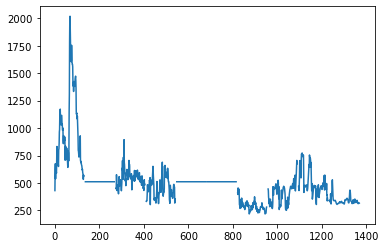

In [38]:
import matplotlib.pyplot as plt
plt.plot(sc2.inverse_transform(regressor.predict(X_test_final)))

In [39]:
X_test_final.shape

(1370, 90, 10)

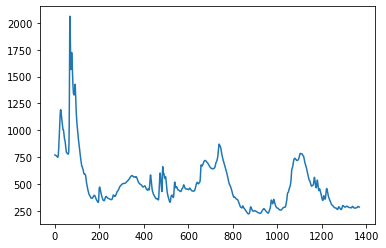

In [40]:
plt.plot(sc2.inverse_transform(y_test_final.reshape(-1,1)))

In [41]:
y_pred_test=sc2.inverse_transform(regressor.predict(X_test_final))
y_pred_test.shape

(1370, 1)

In [42]:
y_test

<xarray.DataArray 'dis24' (time: 1461)>
dask.array<getitem, shape=(1461,), dtype=float32, chunksize=(1461,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2016-12-31
Attributes:
    units:    m3/s

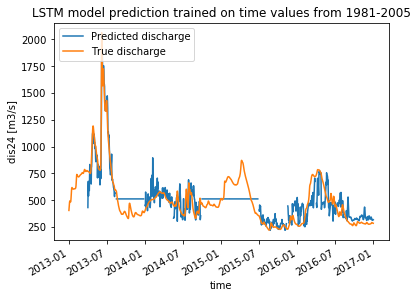

In [43]:
y_pred_test_xr = xr.DataArray(y_pred_test.reshape(-1), dims=('time'), coords={'time': y_test.time.values[days_intake_length+1:]})
y_pred_test_xr.plot(label = "Predicted discharge")

#Plotting the real validation values
#y_valid = np.concatenate(([y_orig.sel(time='2005-12-31').values], y_valid.values)).cumsum()
#y_valid = np.delete(y_valid, 0)
y_test_xr = xr.DataArray(y_test, dims=('time'), coords={'time': y_test.time.values})
y_test_xr.plot(label="True discharge")
plt.title('LSTM model prediction trained on time values from 1981-2005')
plt.legend(loc='upper left')
# plt.savefig('./images/sampleanalysis/LSTM_ver3_multivariate_discharge_validationdata.png', dpi=600)




In [44]:
#Loading the EPS Predictions
eps_masked = eps.where(elbe_basin_mask, drop=True)
eps_masked

<xarray.Dataset>
Dimensions:    (ensemble: 11, latitude: 54, longitude: 71, time: 31)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-17 2013-05-18 ... 2013-06-16
  * longitude  (longitude) float32 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
  * latitude   (latitude) float32 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * ensemble   (ensemble) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    ups        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    ldd        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl2        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl5        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    rl20       (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    dis        (time, ensemble, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Fri Feb 14 21:26:30 2020: cdo -f nc4 -z zip copy tmp.nc /vo...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

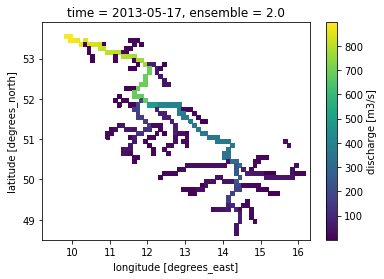

In [45]:
eps_masked.isel(time=0, ensemble=2)['dis'].plot()

In [46]:
#instead of taking the mean you should take a specific point
# mean_eps_masked = eps_masked.mean(['latitude', 'longitude'])['dis']
point_eps_masked = eps_masked.isel(latitude=3, longitude=6)['dis']
point_eps_masked

<xarray.DataArray 'dis' (time: 31, ensemble: 11)>
array([[ 896.2795 ,  896.2795 ,  896.2795 ,  896.2795 ,  896.2795 ,
         896.2795 ,  896.2795 ,  896.2795 ,  896.2795 ,  896.2795 ,
         896.2795 ],
       [ 878.93634,  878.7824 ,  878.93365,  878.97644,  878.99146,
         878.7955 ,  878.7154 ,  878.8842 ,  879.08093,  878.8176 ,
         879.1039 ],
       [ 857.9182 ,  857.4792 ,  857.58704,  857.63025,  858.0234 ,
         857.3593 ,  857.49225,  857.82855,  857.9644 ,  857.75635,
         858.09576],
       [ 835.31464,  835.1533 ,  834.92816,  834.9484 ,  836.0045 ,
         834.3691 ,  835.41986,  835.33826,  835.4386 ,  834.8839 ,
         835.9178 ],
       [ 814.62787,  815.3381 ,  814.517  ,  814.40924,  816.1021 ,
         813.599  ,  815.6413 ,  816.5424 ,  816.57965,  813.0593 ,
         816.2104 ],
       [ 795.94086,  797.7958 ,  797.42896,  796.78204,  797.4017 ,
         795.9883 ,  799.0591 ,  802.75525,  799.8282 ,  793.1473 ,
         799.87897],
       [ 780.22314,  785.9522 ,  784.13513,  783.3901 ,  781.6689 ,
         784.64667,  785.8752 ,  797.71155,  784.39984,  776.9558 ,
         788.4519 ],
       [ 769.0892 ,  782.7042 ,  775.2755 ,  774.8591 ,  771.4458 ,
         779.60486,  775.88934,  798.1477 ,  772.0543 ,  768.59467,
         782.7664 ],
       [ 761.1403 ,  786.2927 ,  769.0048 ,  770.61053,  766.099  ,
         781.3319 ,  767.8854 ,  801.0741 ,  761.8077 ,  766.37286,
         779.9976 ],
       [ 756.0769 ,  791.6253 ,  764.892  ,  768.6997 ,  764.1513 ,
         784.58655,  762.4796 ,  804.8247 ,  753.89703,  763.82007,
         776.3225 ],
       [ 753.7553 ,  795.0346 ,  763.311  ,  767.3406 ,  763.25867,
         785.3768 ,  759.71747,  806.6857 ,  752.8569 ,  756.86206,
         769.53314],
       [ 752.56946,  799.1271 ,  778.26025,  762.9562 ,  760.11096,
         782.11005,  757.03265,  801.1799 ,  768.796  ,  746.8835 ,
         761.4286 ],
       [ 747.96   ,  803.18787,  856.29346,  753.2766 ,  752.0862 ,
         775.91064,  752.5432 ,  787.5307 ,  798.3723 ,  736.69635,
         753.94   ],
       [ 737.01135,  799.84143,  965.4747 ,  740.16956,  740.28516,
         768.618  ,  747.79297,  768.697  ,  814.426  ,  725.97955,
         746.35706],
       [ 722.7618 ,  788.3957 ,  996.7471 ,  726.91565,  727.5804 ,
         762.1995 ,  745.7681 ,  747.73694,  805.4884 ,  714.9995 ,
         737.5628 ],
       [ 708.9221 ,  774.5075 ,  953.125  ,  716.08435,  715.1253 ,
         756.65173,  751.732  ,  726.6725 ,  783.54266,  708.4362 ,
         735.4079 ],
       [ 698.28546,  764.00214,  890.2257 ,  708.4987 ,  702.572  ,
         748.6768 ,  762.6974 ,  707.47314,  762.9731 ,  722.8959 ,
         754.8216 ],
       [ 692.33936,  757.0782 ,  833.7267 ,  703.51294,  690.49603,
         737.26825,  794.15283,  690.67926,  747.2494 ,  777.3028 ,
         790.5086 ],
       [ 694.5847 ,  749.9706 ,  790.0613 ,  698.96405,  679.8365 ,
         724.7511 ,  855.7453 ,  675.49054,  739.30475,  859.67676,
         811.0747 ],
       [ 707.5939 ,  739.48615,  758.3723 ,  691.56146,  670.7245 ,
         713.7145 ,  907.7604 ,  661.9862 ,  744.8046 ,  937.81396,
         806.46564],
       [ 723.73413,  726.1449 ,  737.79047,  681.37305,  662.6412 ,
         704.3446 ,  913.26575,  650.8683 ,  761.2184 ,  987.1938 ,
         790.3901 ],
       [ 736.3257 ,  711.1655 ,  728.42096,  669.98145,  654.0931 ,
         696.6827 ,  887.0694 ,  642.2478 ,  771.1754 ,  992.57605,
         785.2353 ],
       [ 744.88794,  695.4099 ,  728.60266,  658.104  ,  644.582  ,
         693.80304,  857.5565 ,  635.4648 ,  768.5747 ,  965.1228 ,
         805.9065 ],
       [ 751.65564,  681.29205,  730.7658 ,  647.14124,  634.464  ,
         701.9833 ,  841.1647 ,  630.0797 ,  761.75116,  928.7836 ,
         834.1968 ],
       [ 756.13324,  670.06976,  727.60187,  637.7124 ,  623.84717,
         731.8194 ,  839.20496,  627.10864,  754.3068 ,  896.1138 ,
         852.8544 ],
       [ 755.37354,  662.

In [47]:
glofas_point = glofas.loc[dict(time=slice('2013-05-23','2013-06-13'))].isel(latitude=3, longitude=6)

glofas_point

<xarray.Dataset>
Dimensions:    (time: 22)
Coordinates:
    latitude   float64 53.55
    longitude  float64 9.85
  * time       (time) datetime64[ns] 2013-05-23 2013-05-24 ... 2013-06-13
Data variables:
    dis24      (time) float32 dask.array<chunksize=(22,), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.9.6 (http://m...
    Conventions:               CF-1.6
    history:                   Thu Oct 10 12:28:51 2019: cdo -seldate,1999-01...
    cdo_openmp_thread_number:  8
    NCO:                       netCDF Operators version 4.7.8 (Homepage = htt...
    CDO:                       Climate Data Operators version 1.9.6 (http://m...

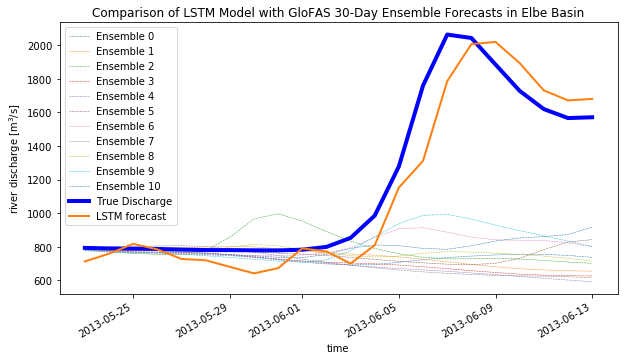

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
color_scheme = ['g', 'cyan', 'magenta', 'k']


for ensemble_index in range(len(point_eps_masked.ensemble)):
    point_eps_masked.loc[dict(time=slice('2013-05-23','2013-06-13'))].isel(ensemble=ensemble_index).plot(ax=ax, label=('Ensemble ' + str(ensemble_index)), lw=0.5, linestyle='--')
    
glofas_point['dis24'].plot(ax=ax, label=('True Discharge'), lw=4, linestyle='-', color='blue')
y_pred_test_xr.loc[dict(time=slice('2013-05-23','2013-06-13'))].plot(ax=ax, label=("LSTM forecast"), lw=2, linestyle='-')
ax.set_ylabel('river discharge [m$^3$/s]')

ax.legend(loc='upper left')                

plt.title('Comparison of LSTM Model with GloFAS 30-Day Ensemble Forecasts in Elbe Basin')
plt.savefig('../../images/regions/Elbe/case_study.png',dpi=600)